In [35]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import RMSprop
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.models import load_model
from keras.utils import get_custom_objects

In [41]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras import backend as K

class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = gamma

    def build(self, input_shape):
        # Create a trainable weight variable for the centers of the RBFs
        self.centers = self.add_weight(name='centers',
                                      shape=(self.units, input_shape[-1]),
                                      initializer='uniform',
                                      trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        # Calculate the radial basis functions for each input sample and each RBF center
        diff = K.expand_dims(inputs) - self.centers  # shape: (batch_size, units, input_dim)
        norm = K.sum(K.square(diff), axis=-1)  # shape: (batch_size, units)
        rbf = K.exp(-self.gamma * norm)  # shape: (batch_size, units)

        return rbf

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.units
    

Training model with gamma = 0.1


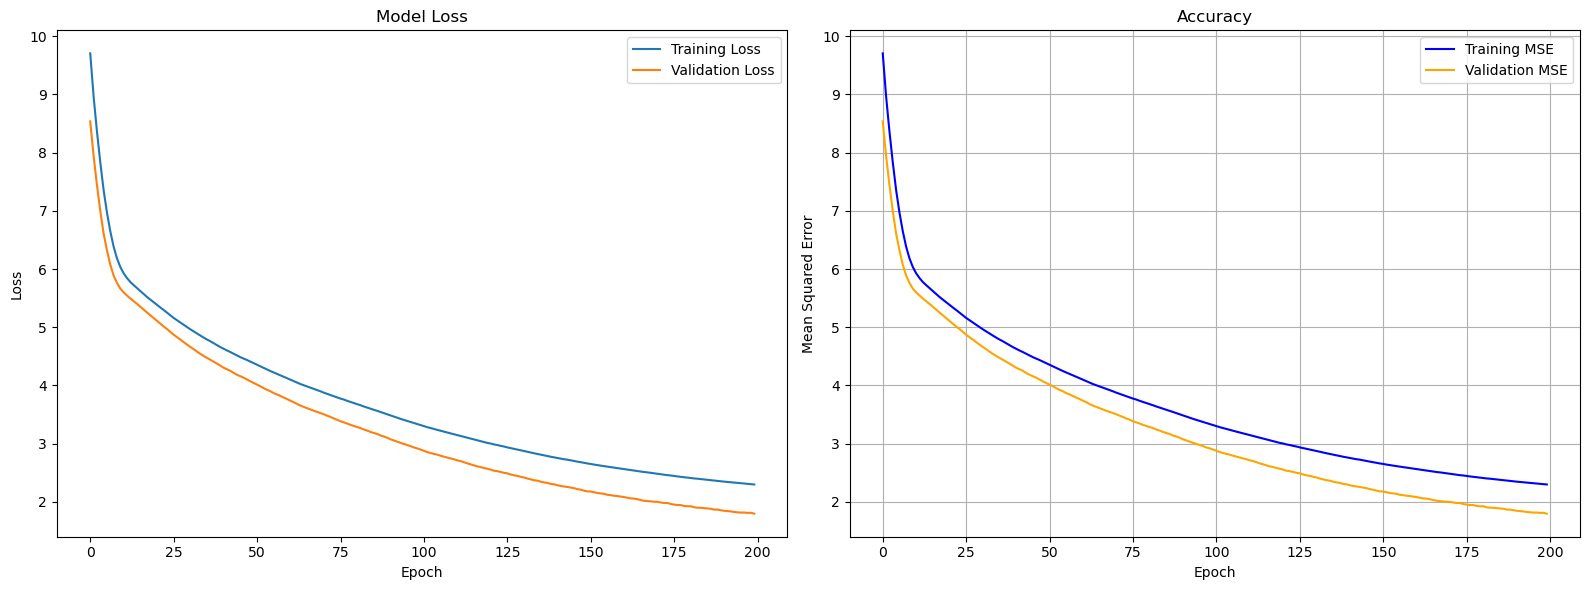

7/7 [==============================] - 0s 1ms/step
Manual MSE: [1.7952714]
Mean Absolute Error (MAE) 1.0168370192701166
R2 Score 0.6920980079062451


<Figure size 1600x600 with 0 Axes>

In [42]:
    df = pd.read_csv('data/RB.csv', delimiter=';')
    X = df.drop(columns=["GOAL","7MSHOT","9MSHOT","6MSHOT","WINGSHOT","PIVOTSHOT","FASTBREAKSHOT"])
    y = df.GOAL
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    for gamma in gamma_values:
        print(f"Training model with gamma = {gamma}")
        
        model = Sequential()
        model.add(Flatten(input_shape=(6,)))
        model.add(RBFLayer(6, gamma))
        model.add(Dense(1, activation='linear'))
        model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_error'])
        
         # Custom callback to collect metrics for plotting
        class MetricsCallback(tf.keras.callbacks.Callback):
            def on_epoch_end(self, epoch, logs=None):
                self.mse_values.append(logs['mean_squared_error'])
                self.mae_values.append(logs['mean_absolute_error'])

            def on_train_begin(self, logs=None):
                self.mse_values = []
                self.mae_values = []

        
        metrics_callback = MetricsCallback()
        history = model.fit(X_train, y_train, batch_size=32, epochs=200, validation_data=(X_test, y_test), callbacks=[metrics_callback], verbose=0)

        plt.figure(figsize=(16, 6))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.epoch, metrics_callback.mse_values, label='Training MSE', color='blue')
        plt.plot(history.epoch, history.history['val_mean_squared_error'], label='Validation MSE', color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('Mean Squared Error')
        plt.title('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()
        plt.figure(figsize=(16, 6))


        pred_test = model.predict(X_test)
        def mean_squared_error1(y_test, pred_test):
            squared_errors = [(true - pred)**2 for true, pred in zip(y_test, pred_test)]
            mse = sum(squared_errors) / len(y_test)
            return mse
    
        mse = mean_squared_error1(y_test, pred_test)
        r2 = r2_score(y_test, pred_test)
        mae = mean_absolute_error(y_test, pred_test)
        print("Manual MSE:", mse)
        print(f"Mean Absolute Error (MAE)",mae)  
        print(f"R2 Score",r2)